# Combo Dataset

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Cell Cycle Phases

In [6]:
data_dir = './data/'

adata = sc.read(os.path.join(data_dir,'combo.filtered.updated.h5ad'))

Only considering the two last: ['.updated', '.h5ad'].
Only considering the two last: ['.updated', '.h5ad'].


In [7]:
cc_phases = np.loadtxt(os.path.join(data_dir,'cell_cycle_genes.csv'),delimiter=',',dtype=str)

cc_phases_dict = {}
for i in range(cc_phases.shape[1]):
    phase = cc_phases[0,i].strip()
    if '\ufeff' in phase:
        phase = phase.split('\ufeff')[1]
    cc_phases_dict[phase] = [val.strip() for val in cc_phases[1:,i] if len(val) > 1]

In [8]:
genes = adata.var.index
filtered_X = adata.X.copy()

from scipy.stats import spearmanr

genes2keep_dict = {phase: [] for phase in cc_phases_dict.keys()}
for phase in cc_phases_dict.keys():
    phase_gene_inds = [list(genes).index(gene) for gene in cc_phases_dict[phase] if gene in genes]
    print(phase,len(phase_gene_inds),'/',len(cc_phases_dict[phase]))
    phase_gene_means = filtered_X[:,phase_gene_inds].mean(1)

    for ind in phase_gene_inds:
#         cells2keep = np.where(filtered_X[:,ind] != 0)[0]
        rho,p = spearmanr(filtered_X[:,ind],phase_gene_means)
        if rho > 0.3:
            genes2keep_dict[phase].append(genes[ind])
    print(phase,len(genes2keep_dict[phase]),'/',len(cc_phases_dict[phase]))
    print('-----')

G1/S 95 / 100
G1/S 30 / 100
-----
S 105 / 113
S 24 / 113
-----
G2/M 130 / 133
G2/M 35 / 133
-----
M 147 / 151
M 50 / 151
-----
M/G1 104 / 106
M/G1 26 / 106
-----


In [9]:
labels = adata.obs['cell_cycle_phase'].values

In [10]:
adata.obs['dataset'] = 'combo'

In [11]:
# NORMALIZE ACROSS PHASES (S.T. NO SINGULAR CELL CYCLE PHASE SCORE/EXPRESSION PROFILES DOMINATES!)
phases = sorted(list(genes2keep_dict.keys()))
cc_scores = np.zeros((filtered_X.shape[0],len(phases)))

for i,phase in enumerate(phases):
    phase_gene_inds = [list(genes).index(gene) for gene in genes2keep_dict[phase]] 
    cc_scores[:,i] = filtered_X[:,phase_gene_inds].mean(1)
    
# NTC (COMBO) ONLY    
combo_inds = np.where((adata.obs['dataset'] == 'combo'))[0]
combo_ntc_inds = np.where((adata.obs['dataset'] == 'combo') & (adata.obs['condition.compact'] == 'NTC'))[0]

cc_scores[combo_inds] = (cc_scores[combo_inds] - cc_scores[combo_ntc_inds].mean(0))/cc_scores[combo_ntc_inds].std(0)

In [12]:
cycling_labels = ((cc_scores < 0).sum(1) != len(phases))

cc_stages = np.array([phases[i] for i in np.argmax(cc_scores,axis=1)])

phase_assignments = []
for i,label in enumerate(cycling_labels):
    if label == 0:
        phase_assignments.append('G0')
    else:
        phase_assignments.append(cc_stages[i])

### Cell Cycle Factors

In [13]:
from sklearn.metrics import roc_auc_score

n_components = 65
cc_phase_list = sorted(list(set(adata.obs['cell_cycle_phase'])))
cc_phase_list.remove('G0')

auroc_mat = np.zeros((n_components,len(cc_phase_list)))
for i in range(n_components):
    y_pred = adata.obsm['X_nmf'][:,i]
    for j,cc_phase in enumerate(cc_phase_list):
        y_true = (adata.obs['cell_cycle_phase'] == cc_phase).astype(int)
        auroc_mat[i,j] = roc_auc_score(y_true,y_pred) 

In [14]:
cell_cycle_factors = np.where((abs(auroc_mat - 0.5) > 0.3).sum(1))[0]
print(np.array(cell_cycle_factors))

sorted(auroc_mat.max(1))[-5:]

[3 6 8]


[0.7256671242553079,
 0.7459296823979422,
 0.8219887779717716,
 0.9145714963706892,
 0.9199704361057356]

### Differential Gene Programs

In [15]:
from scipy.stats import ttest_ind

n_components = 65 #70
perturb_gene_list = sorted(list(set(adata.obs['condition'])))
perturb_gene_list.remove('NTC')

ntc_inds = np.where(adata.obs['condition'] == 'NTC')[0]

p_mat = np.zeros((n_components,len(perturb_gene_list)))
sign_mat = np.zeros(p_mat.shape)

for j,perturb_gene in enumerate(perturb_gene_list):
    print(j)
    filtered_adata = adata[(adata.obs['condition'] == 'NTC') | (adata.obs['condition'] == perturb_gene)]
    for i in range(n_components):
        ntc_vals = adata[adata.obs['condition'] == 'NTC'].obsm['X_nmf'][:,i]
        cond_vals = adata[adata.obs['condition'] == perturb_gene].obsm['X_nmf'][:,i]
        
        t,p = ttest_ind(ntc_vals, cond_vals, axis=0, equal_var=False)
        p_mat[i,j] = p
        sign_mat[i,j] = (cond_vals.mean() > ntc_vals.mean()).astype(int)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [16]:
from statsmodels.stats.multitest import fdrcorrection

q_mat = np.zeros(p_mat.shape)
for j in range(q_mat.shape[1]):
    _,fdr = fdrcorrection(p_mat[:,j])
    q_mat[:,j] = fdr
        
q_mat = -np.log10(q_mat) * (sign_mat-0.5)*2

In [17]:
factors2keep_perturb = np.where((abs(q_mat) > 2).sum(1))[0]
print(np.array(factors2keep_perturb))

conds2keep_perturb = np.where((abs(q_mat) > 2).sum(0))[0]
print(np.array(conds2keep_perturb))

filtered_q_mat = q_mat[factors2keep_perturb][:,conds2keep_perturb]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 48 49 51 53
 54 55 56 57 58 59 60 61 63 64]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [18]:
de_factor_inds = [i for i in factors2keep_perturb if i not in cell_cycle_factors]
print(len(de_factor_inds))
adata.obsm['X_nmf_de'] = adata.obsm['X_nmf'][:,de_factor_inds]

55


/data/cb/alexwu/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical


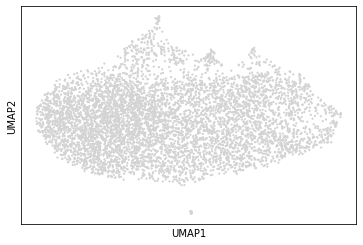

In [19]:
sc.pp.neighbors(adata,use_rep='X_nmf_de',n_neighbors=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

### UMAP per Condition (2 or fewer guides, at least 20 cells)

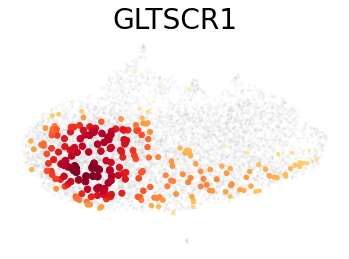

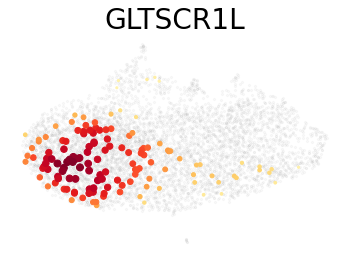

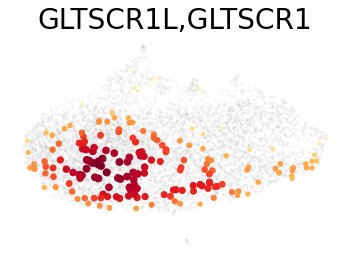

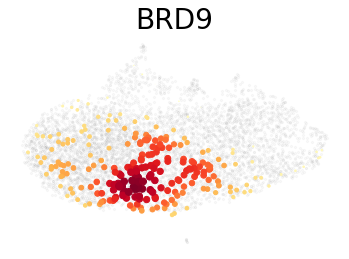

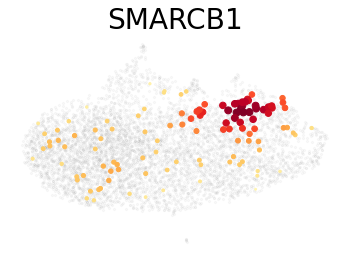

In [61]:
from scipy.stats import gaussian_kde

umap_embeddings = adata.obsm['X_umap']

for condition in ['GLTSCR1','GLTSCR1L','GLTSCR1L,GLTSCR1','BRD9','SMARCB1']:
    if condition.count(',') < 2: # 2 or fewer guides
        inds = np.where(adata.obs['condition'] == condition)[0]
        if len(inds) >= 20: # at least 20 cells
            other_inds = [i for i in range(adata.shape[0]) if i not in inds]

#             plt.figure(figsize=(5,5))
            plt.scatter(umap_embeddings[other_inds,0],umap_embeddings[other_inds,1],c='grey',s=5,alpha=0.05)

            xy = np.vstack([umap_embeddings[inds,0],umap_embeddings[inds,1]])
            z = gaussian_kde(xy)(xy)
            min_z = np.min(z)
            max_z = np.max(z)
            z = (z - min_z) / (max_z - min_z)

            plt.scatter(umap_embeddings[inds,0],umap_embeddings[inds,1],c=z,s=z*50,cmap='YlOrRd')

            plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
            plt.title(condition,fontsize=28)
            plt.axis('off')
            plt.show()


/data/cb/alexwu/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'complex' as categorical


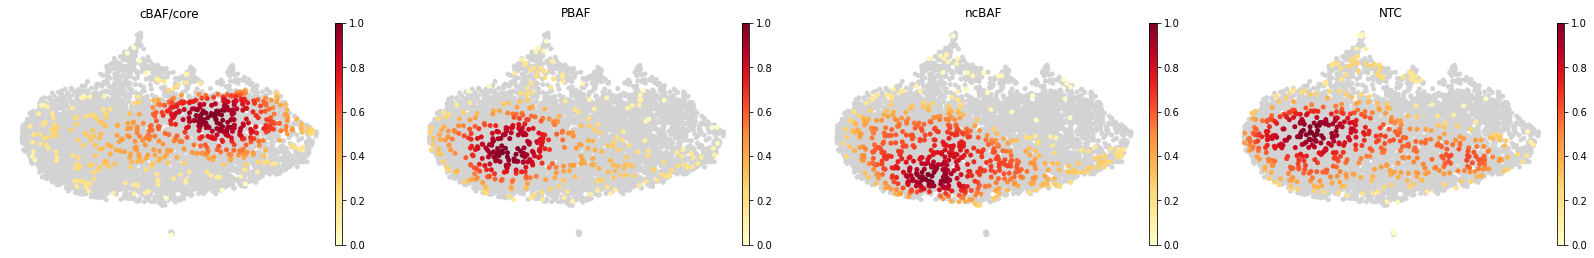

In [18]:
cat1 = ['SMARCA4','ARID1A','SMARCB1','SMARCE1']
cat2 = ['ARID2'] #,'BRD7','PBRM1']
cat3 = ['BRD9','GLTSCR1','SMARCD1']
cat4 = ['NTC']

cat_list = []
for n in adata.obs['condition'].values:
    if n in cat1:
        cat_list.append('cBAF/core')
    elif n in cat2:
        cat_list.append('PBAF')
    elif n in cat3:
        cat_list.append('ncBAF')
    elif n in cat4:
        cat_list.append('NTC')
    else:
        cat_list.append('other')

adata.obs['complex'] = cat_list

sc.tl.embedding_density(adata, basis='umap', groupby='complex')

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'

fg = sc.pl.embedding_density(adata, basis='umap', groupby='complex',group=['cBAF/core','PBAF','ncBAF','NTC'],fg_dotsize=100,\
                       bg_dotsize=100,return_fig=True,frameon=False)


## Combo PCA

In [25]:
cat1 = ['ARID1A','ARID1B','DPF2']
cat2 = ['ARID2','BRD7','PBRM1']
cat3 = ['BRD9','GLTSCR1','GLTSCR1L']
cat_list = [cat1,cat2,cat3]

nmf = adata.obsm['X_nmf_de']
ntc_inds = np.where(adata.obs['condition.compact'] == 'NTC')[0]
ntc_nmf = nmf[ntc_inds]

In [27]:
import itertools

results_dir = '/data/cb/alexwu/baf/plots/most_new/fig5_v2'

color_list = ['blue','red','green']

labels = []
X = []
colors = []
for i,cat in enumerate(cat_list):
    data_dict = {'condition': [], 'dist': [] ,'d1': [],'d2': []}

    for condition in cat:
        inds = np.where(adata.obs['condition'] == condition)[0]
        cond_nmf = nmf[inds].mean(0)
        
        X.append(cond_nmf)
        labels.append(condition)
        colors.append(color_list[i])
        
    for combo in itertools.permutations(cat,2):
        condition = ','.join(combo)
        if condition in adata.obs['condition'].values:
            inds = np.where(adata.obs['condition'] == condition)[0]
            cond_nmf = nmf[inds].mean(0)
            
            X.append(cond_nmf)
            labels.append(condition)
            colors.append(color_list[i])

    for combo in itertools.permutations(cat,3):
        condition = ','.join(combo)
        if condition in adata.obs['condition'].values: # and condition != 'ARID2,BRD7,PBRM1':
            inds = np.where(adata.obs['condition'] == condition)[0]
            cond_nmf = nmf[inds].mean(0)

            X.append(cond_nmf)
            labels.append(condition)
            colors.append(color_list[i])


# NTC
cond_nmf = nmf[np.where(adata.obs['condition'] == 'NTC')].mean(0)
X.append(cond_nmf)
labels.append('NTC')
colors.append('black')
    
X = np.array(X)
labels = np.array(labels)
color = np.array(colors)

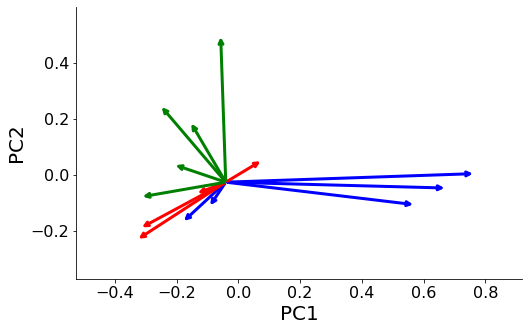

In [31]:
plt.figure(figsize=(8,5))

for i in range(pca_X.shape[0]-1):
    x,y = pca_X[i]
    color = colors[i]
    plt.annotate('',(pca_X[-1,0],pca_X[-1,1]),(x,y),arrowprops={'arrowstyle': '<-','lw':3,'color': color},
                 ha='center')

plt.xlim([min(pca_X[:,0])*1.6,max(pca_X[:,0])*1.2])
plt.ylim([min(pca_X[:,1])*1.6,max(pca_X[:,1])*1.2])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)
plt.show()

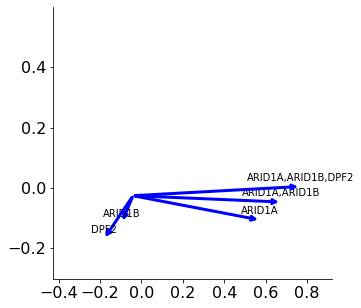

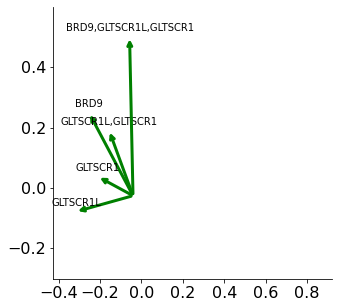

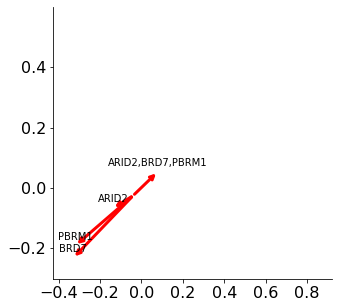

In [30]:
data_df = pd.DataFrame(pca_X,columns=['PC1','PC2'])
data_df['cond'] = labels
data_df['colors'] = colors

ntc_pca_X = tuple(pca_X[-1])

for color,group_df in data_df.groupby('colors'):
    if color != 'black':
        plt.figure(figsize=(5,5))

        for i in range(group_df.shape[0]):
            x,y = group_df[['PC1','PC2']].values[i]
#             color = colors[i]
            plt.annotate('',ntc_pca_X,(x,y),arrowprops={'arrowstyle': '<-','lw':3,'color': color},
                         ha='center')
            plt.annotate(group_df['cond'].values[i],ntc_pca_X,(x,y+0.02),ha='center')

        plt.xlim([min(pca_X[:,0])*1.3,max(pca_X[:,0])*1.2])
        plt.ylim([min(pca_X[:,1])*1.3,max(pca_X[:,1])*1.2])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        sns.despine()
        plt.show()